In [62]:
import importlib
import micasense.imageset
import micasense.capture
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well

from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import extract_spectral as espect
import exiftool
import datetime
from math import ceil

import mutils
import radiometric_calib_utils as rcu
import algorithms.flight_attributes
import algorithms.validate_algorithm

importlib.reload(algorithms.validate_algorithm)
importlib.reload(algorithms.flight_attributes)

import algorithms.flight_attributes as FlightAttributes
import algorithms.validate_algorithm as ValidateAlgo

# Get panel images, panel reflectance, warp matrices

In [4]:
panelNames = None
useDLS = True

# imagePath = os.path.expanduser(os.path.join('~','Downloads','DualCam-Farm','farm_only'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0002_*.tif'))

imagePath =  r"D:\EPMC_flight\8thSur11Aug\F4\RawImg"#r"D:\EPMC_flight\pandanResTest\F2\RawImg"#r"D:\EPMC_flight\pandanResTest\F1\RawImg"
panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))

outputPath = os.path.join(imagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # Set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
    warp_matrices = panelCap.get_warp_matrices()
    cropped_dimensions, _ = imageutils.find_crop_bounds(panelCap, warp_matrices, warp_mode=cv2.MOTION_HOMOGRAPHY)
    print(cropped_dimensions)
else:
    panelCap = None
    warp_matrices = None
if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.65]*len(panelCap.images) #inexact, but quick
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

(4.0, 6.0, 1239.0, 919.0)


# Batch import and process all images

In [5]:
# batch import images
imgset = imageset.ImageSet.from_directory(imagePath)

use_multi_process = True # set to False for single-process saving
overwrite_existing = False # skip existing files, set to True to overwrite

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

# If we didn't provide a panel above, irradiance set to None will cause DLS data to be used
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start_time = datetime.datetime.now()

# Save all captures in the imageset as aligned stacks
imgset.process_imageset(outputPath,
                     thumbnailPath,
                     warp_matrices,
                     irradiance = irradiance,
                     img_type='reflectance',
                     multiprocess=use_multi_process, 
                     overwrite=overwrite_existing)

end_time = datetime.datetime.now()

print("Saving time: {}".format(end_time-start_time))
print("Alignment+Saving rate: {:.2f} captures per second".format(float(len(imgset.captures))/float((end_time-start_time).total_seconds())))

Loading ImageSet from: D:\EPMC_flight\8thSur11Aug\F4\RawImg
Processing 807 Captures ...
Processing complete.
Saving time: 0:35:16.262373
Alignment+Saving rate: 0.38 captures per second


## Import saved band_aligned images

In [6]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0012_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0013_1.jpg',
 'D:\\EPMC_flight\\8thSur11Aug\\F4\\thumbnails\\IMG_0014_1.jpg',
 'D:\\EPMC_flight\\8thSur

## Import flight attributes df

In [7]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

timestamp  latitude   longitude  altitude  \
0    2022-08-11 07:32:48.733511+00:00  1.231972  103.639619    21.759   
1    2022-08-11 07:33:21.350167+00:00  1.231975  103.639608    34.328   
2    2022-08-11 07:33:29.261964+00:00  1.232028  103.639635    61.447   
3    2022-08-11 07:33:30.882589+00:00  1.232077  103.639663    68.484   
4    2022-08-11 07:33:31.883894+00:00  1.232115  103.639683    72.258   
..                                ...       ...         ...       ...   
802  2022-08-11 07:57:10.364564+00:00  1.232099  103.639706    71.762   
803  2022-08-11 07:57:13.185152+00:00  1.232063  103.639681    71.487   
804  2022-08-11 07:57:15.907460+00:00  1.232028  103.639656    71.492   
805  2022-08-11 07:57:18.707079+00:00  1.231992  103.639630    71.496   
806  2022-08-11 07:58:18.721764+00:00  1.231976  103.639610    17.274   

         image_name            capture_id   dls-yaw  dls-pitch  dls-roll  \
0    IMG_0000_1.tif  maBAnK4LoEnAt0jp0NfQ -0.398387  -0.153657  0.015440   
1    IMG_0001_1.tif  AxSCLtHl6aaT7xx4kAES  0.450917  -0.027690  0.062104   
2    IMG_0002_1.tif  nvpipwp9lV7KVItNjiCI  0.545158  -0.119086  0.077580   
3    IMG_0003_1.tif  b85N9aWbEvJ3w4xdzPIS  0.533862  -0.113425  0.089849   
4    IMG_0004_1.tif  BTPIyfSo3PSIQWQOpIDE  0.545036  -0.073118  0.088235   
..              ...                   ...       ...        ...       ...   
802  IMG_0802_1.tif  1D8ZxUvawQ428durQeAg -2.477546  -0.223150 -0.272230   
803  IMG_0803_1.tif  kotN7QDDFH5DgA9R50p0 -2.474511  -0.199940 -0.252430   
804  IMG_0804_1.tif  q176RARW1ii5SLILUzk2 -2.475494  -0.170163 -0.247625   
805  IMG_0805_1.tif  jClhdO9gGPpd54Lx4eUY -2.487981  -0.063642 -0.270472   
806  IMG_0806_1.tif  FZyuRjQlBMk1wSy4lgpL -0.455630  -0.036966  0.015786   

      irr-475   irr-560   irr-668   irr-842   irr-717   irr-444   irr-531  \
0    1.387202  1.281016  1.094351  0.681395  0.842709  1.227629  1.311529   
1    1.389963  1.284418  1.083797  0.679782  0.837092  1.240628  1.315827   
2    1.310040  1.211789  1.023062  0.641866  0.789652  1.169110  1.241141   
3    1.291285  1.194691  1.009034  0.632935  0.778544  1.152070  1.223537   
4    1.280706  1.184994  1.001061  0.627842  0.772221  1.142462  1.213565   
..        ...       ...       ...       ...       ...       ...       ...   
802  1.260502  1.149972  0.969254  0.606413  0.752746  1.124777  1.182508   
803  1.258757  1.148414  0.968094  0.605609  0.751739  1.123076  1.180877   
804  1.252120  1.142293  0.963158  0.602401  0.747779  1.116981  1.174567   
805  1.249346  1.139612  0.960316  0.600716  0.745757  1.114841  1.171889   
806  1.299698  1.204043  1.022183  0.643015  0.793841  1.158820  1.232693   

      irr-650   irr-705   irr-740  
0    1.080445  0.955943  0.878142  
1    1.074632  0.945475  0.866389  
2    1.014241  0.892008  0.817238  
3    1.000151  0.879642  0.805940  
4    0.992135  0.872616  0.799530  
..        ...       ...       ...  
802  0.960873  0.850551  0.781989  
803  0.959642  0.849499  0.781065  
804  0.954637  0.845139  0.777147  
805  0.952027  0.842701  0.774842  
806  1.014580  0.894267  0.818961  

[807 rows x 19 columns]

### View flight altitude

78.516


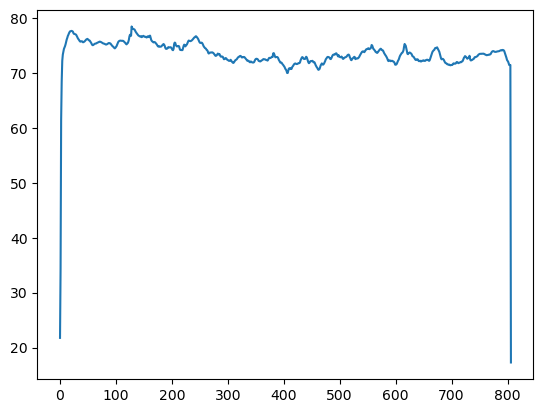

In [8]:
plt.figure()
plt.plot(flight_attributes_df.index.to_list(),flight_attributes_df['altitude'])
# plt.title(f'Max height: {}')
print(np.max(flight_attributes_df['altitude'].values))
plt.show()

# Interpolate Flight

0it [00:00, ?it/s]

807it [00:00, 1201.02it/s]
807it [00:00, 1478.63it/s]


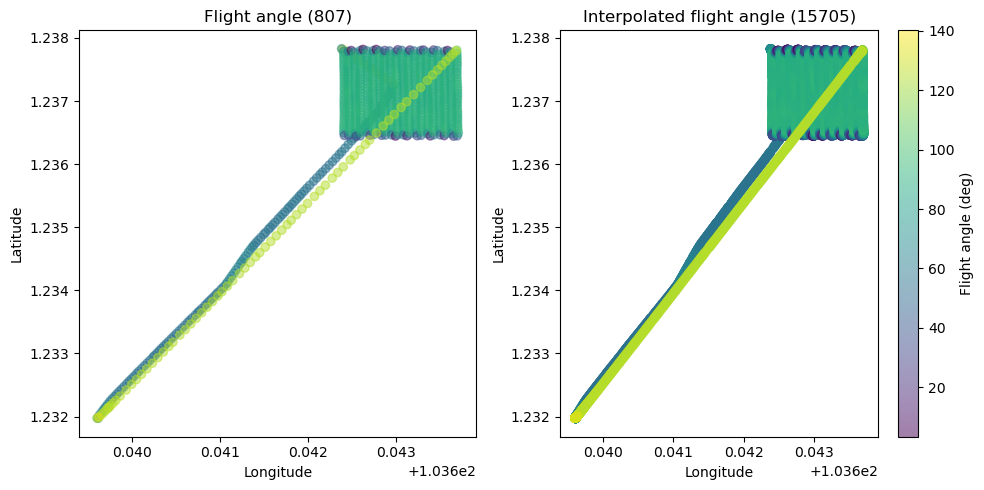

timestamp    timedelta  latitude   longitude  \
0     2022-08-11 07:32:48.733511+00:00     0.000000  1.231972  103.639619   
1     2022-08-11 07:32:48.833511+00:00     0.100000  1.231972  103.639619   
2     2022-08-11 07:32:48.933511+00:00     0.200000  1.231972  103.639619   
3     2022-08-11 07:32:49.033511+00:00     0.300000  1.231972  103.639619   
4     2022-08-11 07:32:49.133511+00:00     0.400000  1.231972  103.639619   
...                                ...          ...       ...         ...   
15700 2022-08-11 07:58:18.407079+00:00  1529.673568  1.231976  103.639610   
15701 2022-08-11 07:58:18.507079+00:00  1529.773568  1.231976  103.639610   
15702 2022-08-11 07:58:18.607079+00:00  1529.873568  1.231976  103.639610   
15703 2022-08-11 07:58:18.707079+00:00  1529.973568  1.231976  103.639610   
15704 2022-08-11 07:58:18.721764+00:00  1529.973568  1.231976  103.639610   

        altitude  flight_angle  north_vec  east_vec      image_name  \
0      21.759000     73.537827   0.000055  0.000016  IMG_0000_1.tif   
1      21.797536     73.537827   0.000055  0.000016  IMG_0000_1.tif   
2      21.836071     73.537827   0.000055  0.000016  IMG_0000_1.tif   
3      21.874607     73.537827   0.000055  0.000016  IMG_0000_1.tif   
4      21.913142     73.537827   0.000055  0.000016  IMG_0000_1.tif   
...          ...           ...        ...       ...             ...   
15700  17.558311    131.585997  -0.000052 -0.000047  IMG_0805_1.tif   
15701  17.467963    131.585997  -0.000052 -0.000047  IMG_0805_1.tif   
15702  17.377615    131.585997  -0.000052 -0.000047  IMG_0805_1.tif   
15703  17.287268    131.585997  -0.000052 -0.000047  IMG_0805_1.tif   
15704  17.274000    131.585997  -0.000052 -0.000047  IMG_0806_1.tif   

                 capture_id  ...   irr-560   irr-668   irr-842   irr-717  \
0      maBAnK4LoEnAt0jp0NfQ  ...  1.281016  1.094351  0.681395  0.842709   
1      maBAnK4LoEnAt0jp0NfQ  ...  1.281016  1.094351  0.681395  0.842709   
2      maBAnK4LoEnAt0jp0NfQ  ...  1.281016  1.094351  0.681395  0.842709   
3      maBAnK4LoEnAt0jp0NfQ  ...  1.281016  1.094351  0.681395  0.842709   
4      maBAnK4LoEnAt0jp0NfQ  ...  1.281016  1.094351  0.681395  0.842709   
...                     ...  ...       ...       ...       ...       ...   
15700  jClhdO9gGPpd54Lx4eUY  ...  1.139612  0.960316  0.600716  0.745757   
15701  jClhdO9gGPpd54Lx4eUY  ...  1.139612  0.960316  0.600716  0.745757   
15702  jClhdO9gGPpd54Lx4eUY  ...  1.139612  0.960316  0.600716  0.745757   
15703  jClhdO9gGPpd54Lx4eUY  ...  1.139612  0.960316  0.600716  0.745757   
15704  FZyuRjQlBMk1wSy4lgpL  ...  1.204043  1.022183  0.643015  0.793841   

        irr-444   irr-531   irr-650   irr-705   irr-740  index  
0      1.227629  1.311529  1.080445  0.955943  0.878142      0  
1      1.227629  1.311529  1.080445  0.955943  0.878142      0  
2      1.227629  1.311529  1.080445  0.955943  0.878142      0  
3      1.227629  1.311529  1.080445  0.955943  0.878142      0  
4      1.227629  1.311529  1.080445  0.955943  0.878142      0  
...         ...       ...       ...       ...       ...    ...  
15700  1.114841  1.171889  0.952027  0.842701  0.774842    805  
15701  1.114841  1.171889  0.952027  0.842701  0.774842    805  
15702  1.114841  1.171889  0.952027  0.842701  0.774842    805  
15703  1.114841  1.171889  0.952027  0.842701  0.774842    805  
15704  1.158820  1.232693  1.014580  0.894267  0.818961    806  

[15705 rows x 24 columns]

In [10]:
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None
IF = FlightAttributes.InterpolateFlight(flight_attributes_df)
df_interpolated = IF.interpolate_flight()
df_interpolated

# Georeference images

In [15]:
parent_dir = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in flight_attributes_df.iterrows():
    if (i == 0) or (i == len(flight_attributes_df.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        image_name = os.path.splitext(rows['image_name'])[0]
        # estimate flight angle from 2 adjacent coordinates
        flight_att_diff = flight_attributes_df.iloc[[i-1,i+1],column_idx]
        flight_att_diff = flight_att_diff.iloc[:,:2].values
        flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
        flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
        flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
        if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
            flight_angle_coord = (flight_angle_coord + 180)%360
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print(f"Image not found: {image_name}, {fp_list[i]}")
            pass
        else:
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

Image not found: IMG_0768_1, D:\EPMC_flight\8thSur11Aug\F4\thumbnails\IMG_0767_1.jpg
Image not found: IMG_0767_1, D:\EPMC_flight\8thSur11Aug\F4\thumbnails\IMG_0768_1.jpg


### test

[1.2372207, 103.6424548, 57.185, 0.0954391459763191]
Flight angle from coords: 91.635
Flight direction: (9.460000000016677e-05, -2.6999999960253263e-06)


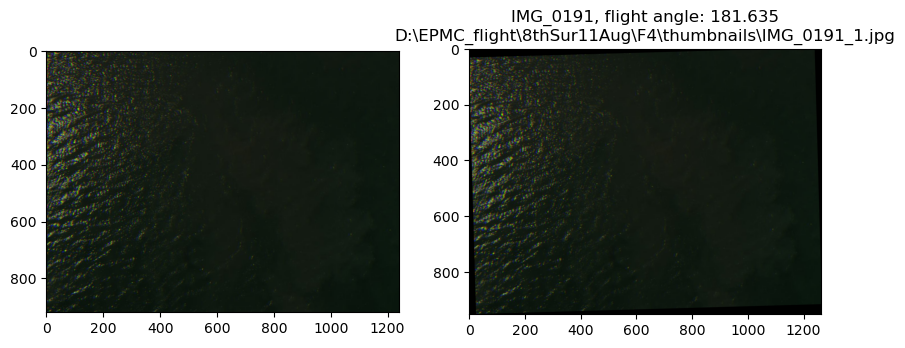

In [16]:
# import image and flight attributes
test_idx = 191
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
flight_att = flight_attributes_df.iloc[test_idx,column_idx].tolist()
flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None
print(flight_att)

# # estimate flight angle from yaw
# fn,_ = flight_attributes.get_flight_angle_fn()
# flight_angle = fn(flight_att[-1])/np.pi*180
# print(f'Flight angle from yaw: {flight_angle:.3f}')
# flight_angle = flight_angle + 90 if flight_angle > 90 else 90 - flight_angle

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
print(f'Flight angle from coords: {flight_angle_coord[0]:.3f}')
print(f'Flight direction: {flight_dir}')
flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
    flight_angle_coord = (flight_angle_coord + 180)%360
# estimation of flight angle from coordinates is better
# geotransform image
GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
rot_im = GI.georegister()
# _ = GI.affine_transformation(plot=True)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(im)
axes[1].imshow(np.fliplr(rot_im)) #need to fliplr cus QGIS
axes[1].set_title(f'{image_name}, flight angle: {flight_angle_coord:.3f}\n{fp_list[test_idx]}')
plt.show()

# Time delay correction

rows shifted: 0
shape of canvas(4294, 5342, 3)


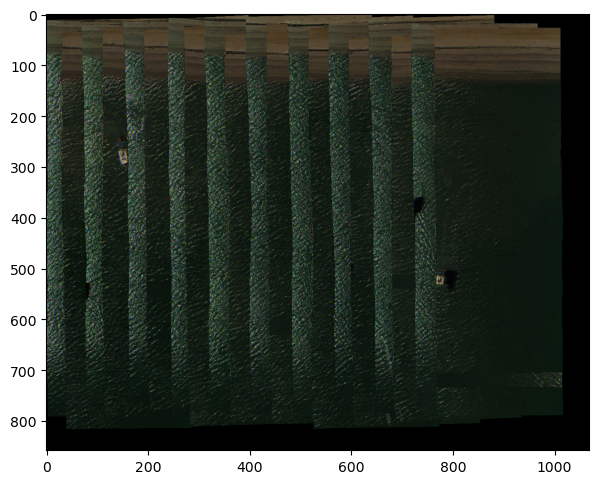

In [21]:
selected_imges = [list(range(149,171)),list(range(178,200)),list(range(208,229)),list(range(238,259)),list(range(267,288)),list(range(297,318)),list(range(326,348)),list(range(355,377)),list(range(384,406)),list(range(414,435)),list(range(443,465)),list(range(473,495)),list(range(502,524)),list(range(531,553)),list(range(561,582)),list(range(590,611)),list(range(619,641)),list(range(649,670)),list(range(678,699)),list(range(708,729))]
selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}
df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=0)
df_cropped = df1.iloc[[i for l in selected_imges_dict.values() for i in l],:]
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list)
fig, axes = plt.subplots(figsize=(7,15))
im_display = PG.plot_georeference(reduction_factor=5,plot=False)
axes.imshow(im_display)
plt.show()

rows shifted: -15
shape of canvas(4260, 2345, 3)
rows shifted: -13
shape of canvas(4227, 2344, 3)
rows shifted: -13
shape of canvas(4227, 2344, 3)
rows shifted: -11
shape of canvas(4194, 2341, 3)
rows shifted: -11
shape of canvas(4194, 2341, 3)
rows shifted: -10
shape of canvas(4177, 2341, 3)
rows shifted: -9
shape of canvas(4159, 2342, 3)
rows shifted: -8
shape of canvas(4137, 2342, 3)


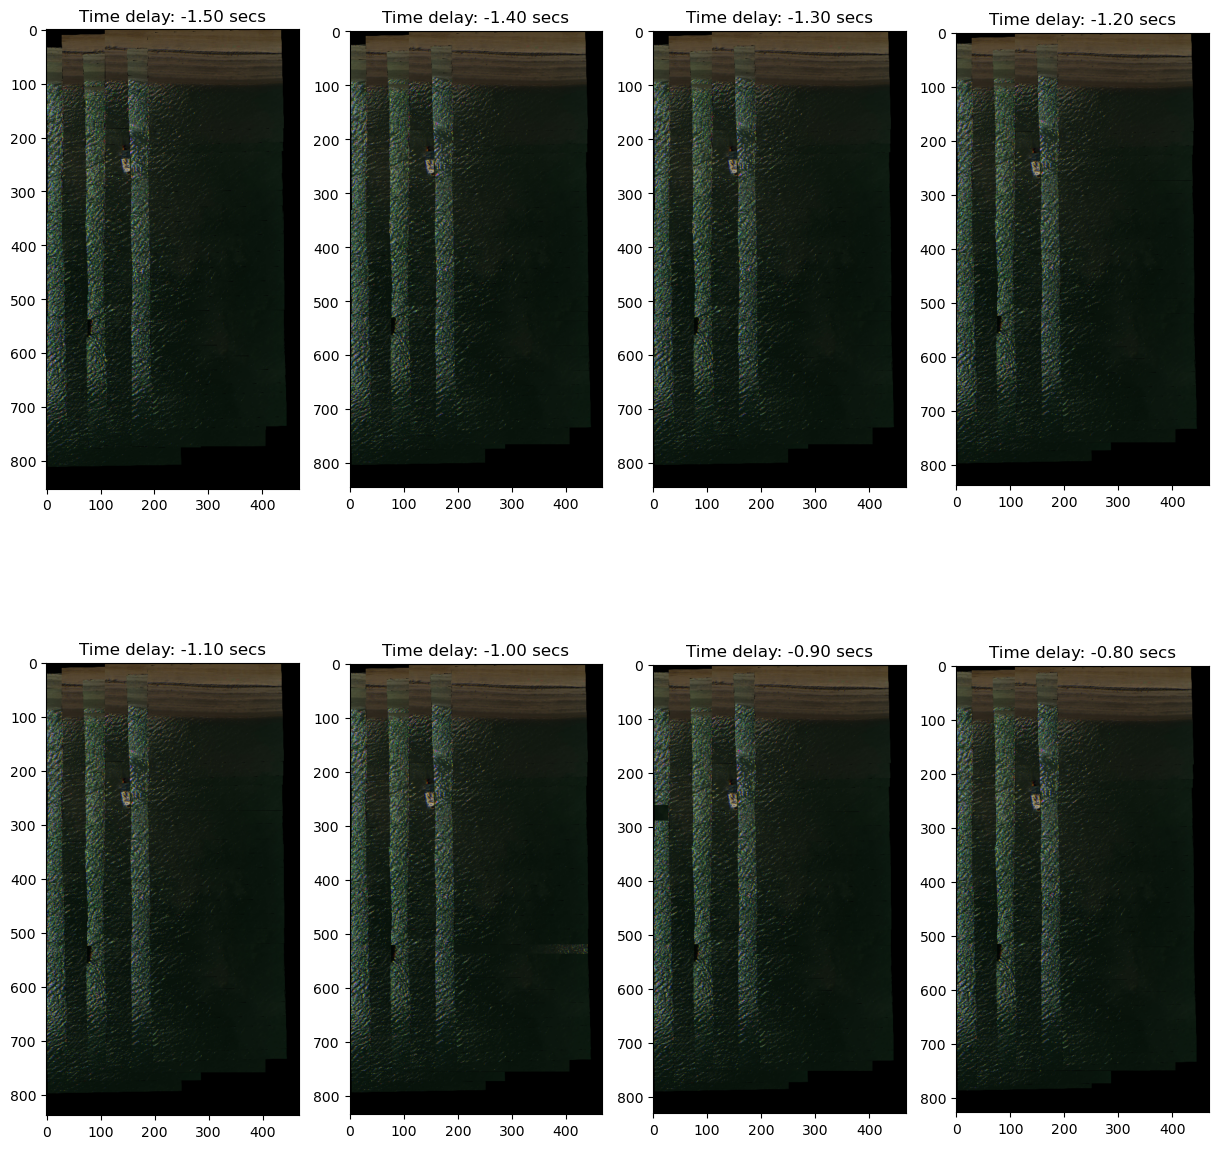

In [28]:
n_fig = 8
fig, axes = plt.subplots(2,4, figsize=(15,15))
selected_idxes = [p for i in range(6) for p in selected_imges_dict[i]]
selected_idxes
for i, (td,ax) in enumerate(zip(np.linspace(-1.5,-0.8, n_fig),axes.flatten())):
    df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
    df_cropped = df1.iloc[selected_idxes,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.set_title(f'Time delay: {td:.2f} secs')

plt.show()

# Correct georeferencing

In [29]:
parent_dir = os.path.join(os.path.dirname(imagePath),'corrected_georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'corrected_georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

DEM_offset_height = flight_attributes_df['altitude'].min()
# perform time delay correction
td = -1.5
df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)

column_idx = [i for i,c in enumerate(df_corrected.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in df_corrected.iterrows():
    if (i == 0) or (i == len(df_corrected.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        flight_angle_coord = rows['flight_angle']
        flight_angle_coord = flight_angle_coord + 90 if flight_angle_coord > 90 else 90 - flight_angle_coord
        if (rows['north_vec'] > 0 and rows['east_vec'] > 0) or (rows['north_vec'] < 0 and rows['east_vec'] < 0):
            flight_angle_coord = (flight_angle_coord + 180)%360
        image_name = os.path.splitext(rows['image_name'])[0]
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print("Image not found")
            break
        else:
            # image_name = os.path.splitext(image_name)[0]
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

rows shifted: -15


# Import WQL info

In [38]:
wql_csv = r"D:\EPMC_flight\8thSur11Aug\F4\Sampling\probe_sampling.csv"
tss_df = pd.read_csv(wql_csv, skiprows=8,engine='python')
tss_df = tss_df.iloc[365:,:]
tss_lat = tss_df['Latitude'].to_list()
tss_lon = tss_df['Longitude'].to_list()
tss_measurements = tss_df.iloc[:,11].to_list()
wql_dict = {'lat':tss_lat,'lon':tss_lon,'measurements':tss_measurements}

### select image lines

In [36]:
# selected_imges = [list(range(138,160)) , list(range(168,190)) , list(range(199,219)) , list(range(229,249)) , list(range(259,279)) , list(range(289,309)) , list(range(319,338)) , list(range(350,369)) , list(range(379,397)) , list(range(409,427)) , list(range(439,457)) , list(range(468,486)) , list(range(499,517)) , list(range(527,545)) , list(range(559,577)) , list(range(586,604)) , list(range(618,636)) , list(range(645,664)) , list(range(677,695)) , list(range(705,728))]
# selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}
selected_imges = [list(range(149,171)),list(range(178,200)),list(range(208,229)),list(range(238,259)),list(range(267,288)),list(range(297,318)),list(range(326,348)),list(range(355,377)),list(range(384,406)),list(range(414,435)),list(range(443,465)),list(range(473,495)),list(range(502,524)),list(range(531,553)),list(range(561,582)),list(range(590,611)),list(range(619,641)),list(range(649,670)),list(range(678,699)),list(range(708,729))]
selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}

selected_idxes = selected_imges_dict[6]
# fig, axes = plt.subplots(figsize=(15,10))
td = -1.5
df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
df_cropped = df1.iloc[selected_idxes,:]
df_cropped

rows shifted: -15


image_name                        timestamp   timedelta  latitude  \
326  IMG_0326_1.tif 2022-08-11 07:43:39.885052+00:00  651.151541  1.237608   
327  IMG_0327_1.tif 2022-08-11 07:43:41.670584+00:00  652.937073  1.237563   
328  IMG_0328_1.tif 2022-08-11 07:43:43.377141+00:00  654.643630  1.237519   
329  IMG_0329_1.tif 2022-08-11 07:43:45.180715+00:00  656.447204  1.237471   
330  IMG_0330_1.tif 2022-08-11 07:43:46.975619+00:00  658.242108  1.237423   
331  IMG_0331_1.tif 2022-08-11 07:43:48.772867+00:00  660.039356  1.237374   
332  IMG_0332_1.tif 2022-08-11 07:43:50.670982+00:00  661.937471  1.237324   
333  IMG_0333_1.tif 2022-08-11 07:43:52.330606+00:00  663.597095  1.237281   
334  IMG_0334_1.tif 2022-08-11 07:43:54.187696+00:00  665.454185  1.237231   
335  IMG_0335_1.tif 2022-08-11 07:43:55.990626+00:00  667.257115  1.237182   
336  IMG_0336_1.tif 2022-08-11 07:43:57.785023+00:00  669.051512  1.237146   
337  IMG_0337_1.tif 2022-08-11 07:44:00.371585+00:00  671.638074  1.237063   
338  IMG_0338_1.tif 2022-08-11 07:44:01.371585+00:00  672.638074  1.237036   
339  IMG_0339_1.tif 2022-08-11 07:44:03.183611+00:00  674.450100  1.236986   
340  IMG_0340_1.tif 2022-08-11 07:44:04.945610+00:00  676.212099  1.236940   
341  IMG_0341_1.tif 2022-08-11 07:44:06.787754+00:00  678.054243  1.236887   
342  IMG_0342_1.tif 2022-08-11 07:44:08.645101+00:00  679.911590  1.236839   
343  IMG_0343_1.tif 2022-08-11 07:44:10.382650+00:00  681.649139  1.236792   
344  IMG_0344_1.tif 2022-08-11 07:44:12.182981+00:00  683.449470  1.236741   
345  IMG_0345_1.tif 2022-08-11 07:44:14.063913+00:00  685.330402  1.236689   
346  IMG_0346_1.tif 2022-08-11 07:44:15.824395+00:00  687.090884  1.236657   
347  IMG_0347_1.tif 2022-08-11 07:44:18.369435+00:00  689.635924  1.236578   

      longitude   altitude  flight_angle  north_vec      east_vec  \
326  103.642806  72.896998     89.838117  -0.000090  2.520257e-07   
327  103.642807  72.941343     89.298457  -0.000089  1.091066e-06   
328  103.642807  72.960475     89.018393  -0.000094  1.615841e-06   
329  103.642808  72.897815     88.928411  -0.000095  1.783570e-06   
330  103.642809  72.787351     88.775635  -0.000100  2.133844e-06   
331  103.642810  72.672379     88.932162  -0.000097  1.804871e-06   
332  103.642811  72.524081     89.958798  -0.000092  7.312547e-08   
333  103.642811  72.403574     90.345015  -0.000096 -5.846292e-07   
334  103.642810  72.268179     89.334440  -0.000097  1.130354e-06   
335  103.642812  72.277766     88.176969  -0.000097  3.088277e-06   
336  103.642813  72.276018     88.161731  -0.000097  3.114925e-06   
337  103.642815  72.095923     89.346994  -0.000098  1.117220e-06   
338  103.642815  72.035770     89.444074  -0.000098  9.516592e-07   
339  103.642816  71.999974     88.709004  -0.000097  2.176959e-06   
340  103.642817  72.113440     89.095708  -0.000101  1.585731e-06   
341  103.642817  72.093159     90.085418  -0.000099 -1.344467e-07   
342  103.642817  71.998261     90.146762  -0.000093 -2.410145e-07   
343  103.642817  71.966670     90.066656  -0.000102 -1.166820e-07   
344  103.642817  71.945456     90.144792  -0.000103 -2.594954e-07   
345  103.642817  71.954633     89.809731  -0.000093  2.964276e-07   
346  103.642817  72.003755     89.564039  -0.000091  6.886130e-07   
347  103.642817  72.324012     90.074630  -0.000096 -1.248069e-07   

               capture_id  ...   irr-560   irr-668   irr-842   irr-717  \
326  7ITRpo0QUiYdaigZmHQi  ...  1.118758  0.936681  0.589858  0.729776   
327  TYG0OUefDSBpBra3LJxi  ...  1.103856  0.925294  0.581879  0.720725   
328  zDQ48eVkMznPZNH58ltM  ...  1.091477  0.915502  0.575179  0.713052   
329  qogHSfrzEZy6asR1olXS  ...  1.081919  0.908175  0.570134  0.707238   
330  fsX27DCtjprPQVOvq4EJ  ...  1.074408  0.902421  0.566133  0.702616   
331  eiFIDe6ug5GdDMqk257t  ...  1.068638  0.897992  0.563056  0.699049   
332  ruYO8xNsxXop0ySTzX6p  ...  1.064644  0.895216  0.561042  0.696706   
333  nhuuW1O9TuDyICS3dkyT  ...  1.

### Plot imageries and wql

shape of canvas(4229, 1339, 3)


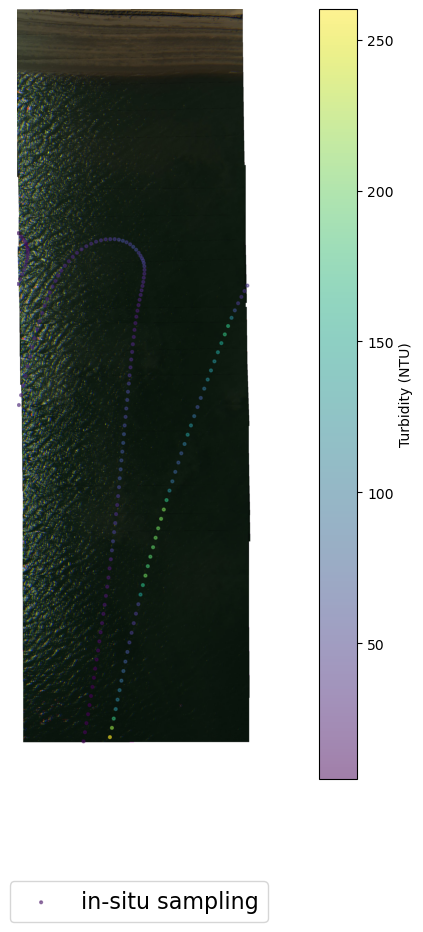

In [39]:
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,wql_dict,
                                       DEM_offset_height=flight_attributes_df['altitude'].min())
_ = PG.plot_georeference(reduction_factor = 5, plot = True, add_wql=True,
                         s=4)

[1.2366388, 103.6428171, 54.763999999999996, 3.0242828424230046]
Flight angle from coords: 89.430
Flight direction: (-9.040000000015702e-05, 9.000000034120603e-07)


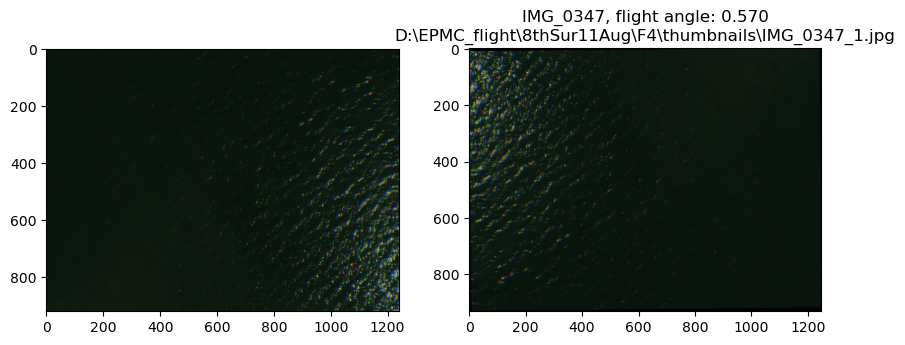

In [41]:
# import image and flight attributes
test_idx = 347
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
flight_att = flight_attributes_df.iloc[test_idx,column_idx].tolist()
flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None
print(flight_att)

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
print(f'Flight angle from coords: {flight_angle_coord[0]:.3f}')
print(f'Flight direction: {flight_dir}')
flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
    flight_angle_coord = (flight_angle_coord + 180)%360
# estimation of flight angle from coordinates is better
# geotransform image
GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
rot_im = GI.georegister()
# _ = GI.affine_transformation(plot=True)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(im)
axes[1].imshow(np.fliplr(rot_im)) #need to fliplr cus QGIS
axes[1].set_title(f'{image_name}, flight angle: {flight_angle_coord:.3f}\n{fp_list[test_idx]}')
plt.show()

# Sun glint corrections

In [40]:
import algorithms.Hedley as Hedley
import algorithms.SUGAR as sugar
import algorithms.Goodman as Goodman

obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


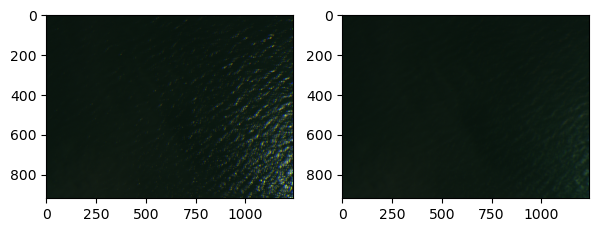

In [42]:
bbox = [(1000,800),(1200,900)]
selected_idxes = selected_imges_dict[6]

parent_dir = os.path.join(os.path.dirname(imagePath),'reflectance_images')
if not os.path.exists(parent_dir):
    reflectance_directory = os.path.join(os.path.dirname(imagePath),'reflectance_images')
    os.mkdir(reflectance_directory)

parent_dir = os.path.join(os.path.dirname(imagePath),'sugar_corrected_images')
if not os.path.exists(parent_dir):
    sugar_corrected_directory = os.path.join(os.path.dirname(imagePath),'sugar_corrected_images')
    os.mkdir(sugar_corrected_directory)

parent_dir = os.path.join(os.path.dirname(imagePath),'hedley_corrected_images')
if not os.path.exists(parent_dir):
    hedley_corrected_directory = os.path.join(os.path.dirname(imagePath),'hedley_corrected_images')
    os.mkdir(hedley_corrected_directory)

parent_dir = os.path.join(os.path.dirname(imagePath),'goodman_corrected_images')
if not os.path.exists(parent_dir):
    goodman_corrected_directory = os.path.join(os.path.dirname(imagePath),'goodman_corrected_images')
    os.mkdir(goodman_corrected_directory)

img_list = [os.path.join(imagePath,f'IMG_{str(i).zfill(4)}_1.tif') for i in selected_idxes]

for i, fp in enumerate(img_list):
    fn = os.path.splitext(os.path.basename(fp))[0]
    reflectance_fn = os.path.join(reflectance_directory,f'{fn}.ob')
    sugar_fn = os.path.join(sugar_corrected_directory,f'{fn}.ob')
    hedley_fn = os.path.join(hedley_corrected_directory,f'{fn}.ob')
    goodman_fn = os.path.join(goodman_corrected_directory,f'{fn}.ob')

    cap = mutils.import_captures(fp)
    RI = espect.ReflectanceImage(cap,warp_matrices,cropped_dimensions)
    print('obtaining reflectance...')
    im_aligned = RI.get_aligned_reflectance()
    print('correcting with sugar...')
    corrected_bands = sugar.correction_iterative(im_aligned,iter=3,plot=False)
    print('correcting with Hedley...')
    HH = Hedley.Hedley(im_aligned,bbox,smoothing=False,glint_mask=False)
    corrected_Hedley = HH.get_corrected_bands(plot=False)
    corrected_Hedley = np.stack(corrected_Hedley,axis=2)
    print('correcting with Goodman...')
    GM = Goodman.Goodman(im_aligned)
    corrected_Goodman = GM.get_corrected_bands()
    corrected_Goodman = np.stack(corrected_Goodman,axis=2)
    
    with open(reflectance_fn,'wb') as f:
        pickle.dump(im_aligned,f)
    with open(sugar_fn,'wb') as f:
        pickle.dump(corrected_bands[-1],f)
    with open(hedley_fn,'wb') as f:
        pickle.dump(corrected_Hedley,f)
    with open(goodman_fn,'wb') as f:
        pickle.dump(corrected_Goodman,f)

fig, axes = plt.subplots(1,2,figsize=(7,3))
axes[0].imshow(np.take(im_aligned,[2,1,0],axis=2))
axes[1].imshow(np.take(corrected_bands[-1],[2,1,0],axis=2))
plt.show()

# Extract spectral information

In [63]:
selected_idxes = selected_imges_dict[6]
reflectance_dirs = [reflectance_directory, hedley_corrected_directory, goodman_corrected_directory, sugar_corrected_directory]
titles = ['R_T','Hedley','Goodman','SUGAR']
td = -1.5
DEM_offset_height = flight_attributes_df['altitude'].min()

CIS = FlightAttributes.CompareInsituSpectral(selected_idxes,reflectance_dirs,df_interpolated,wql_dict,
                                             titles,timedelta=td,DEM_offset_height=DEM_offset_height)
CIS.extract_spectral(save_dir = os.path.split(imagePath)[0])


rows shifted: -15


c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in

extracted spectral data saved in D:\EPMC_flight\8thSur11Aug\F4\Extracted_Spectral_Information


shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of canvas(4229, 1339, 3)


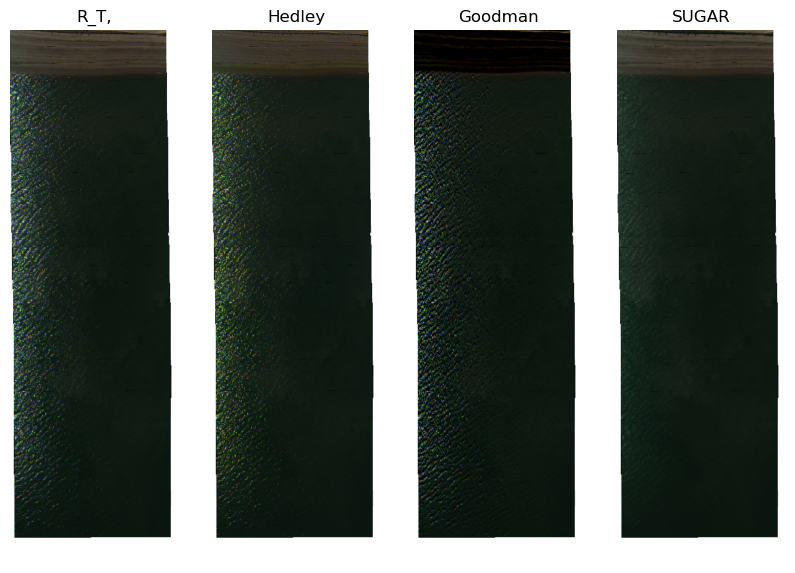

In [64]:
CIS.compare_rgb()

# Analyse extracted spectral

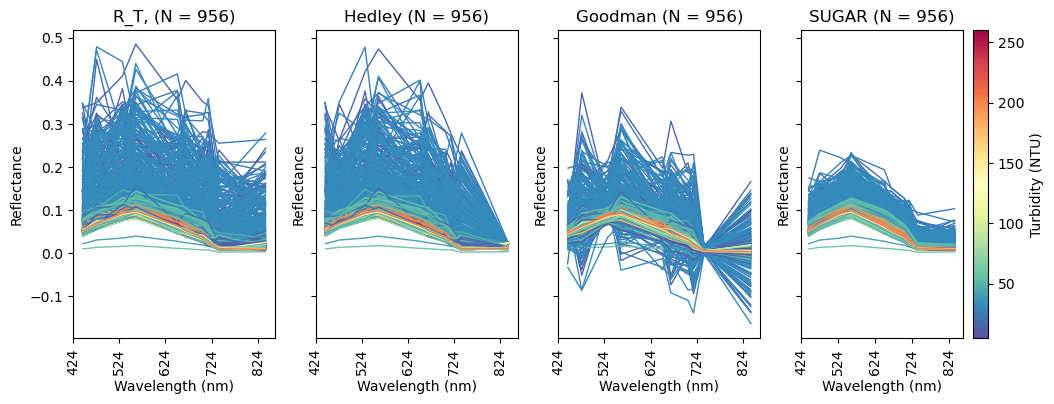

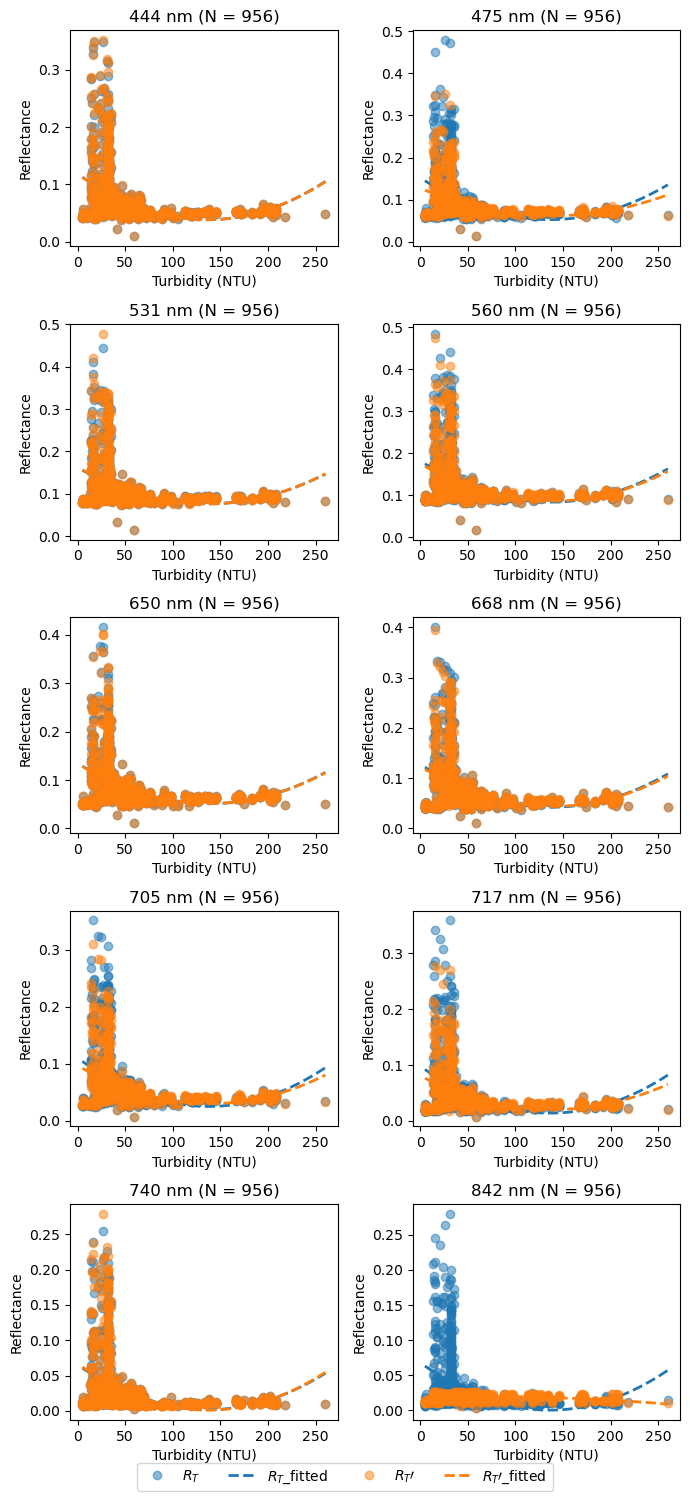

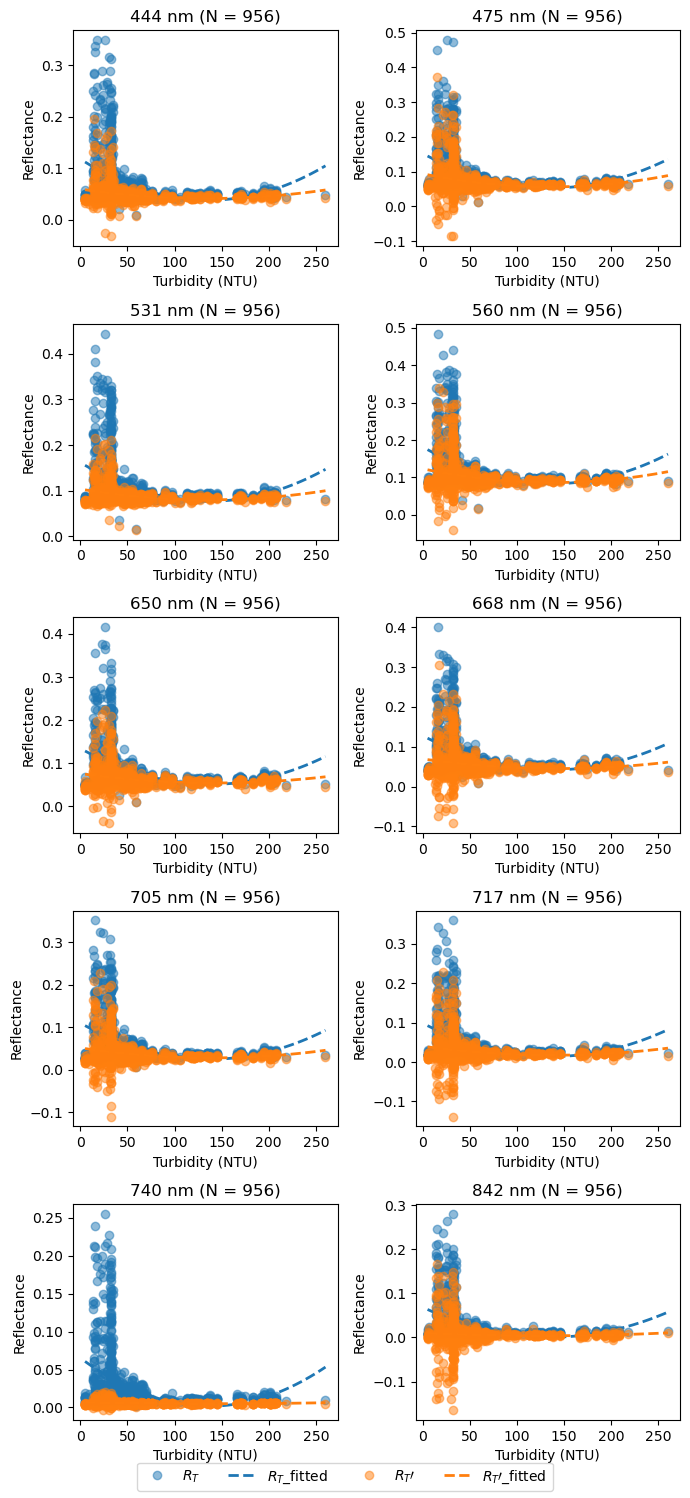

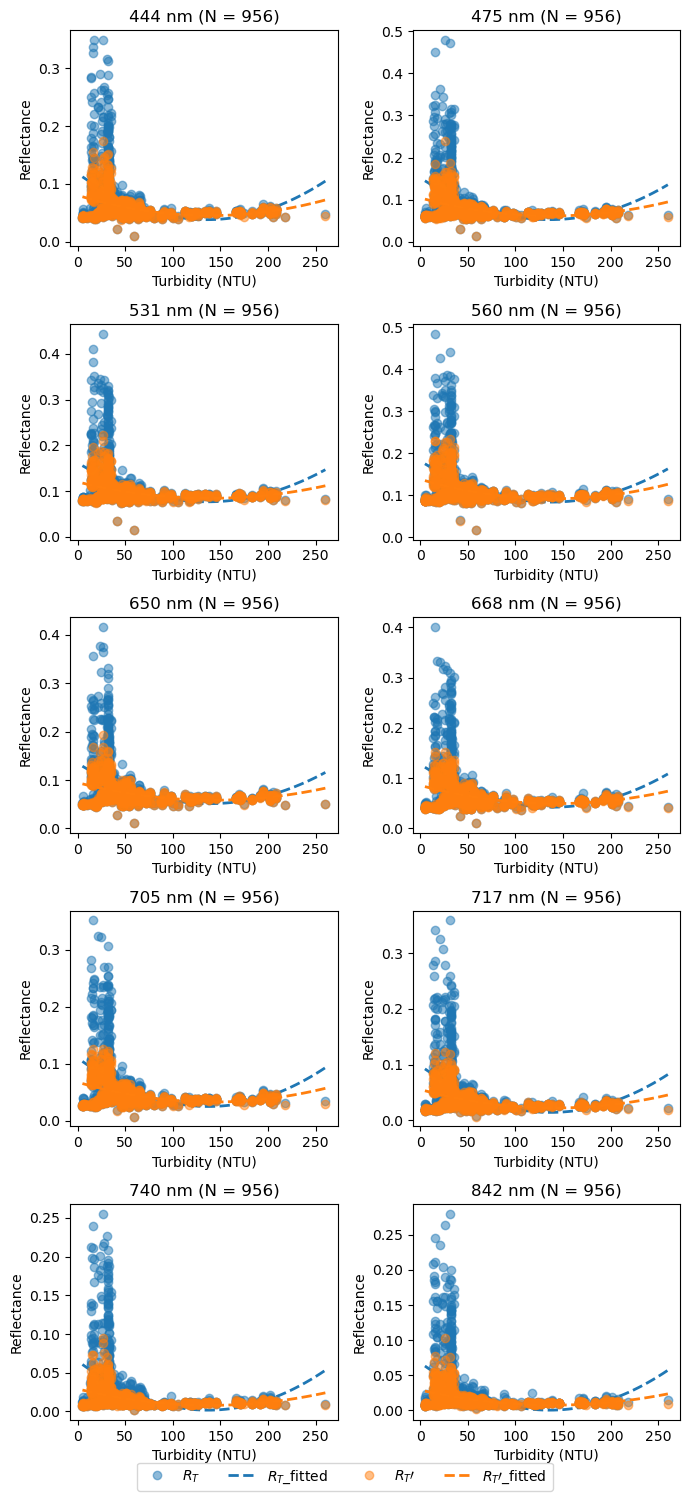

original    Hedley   Goodman     SUGAR
Wavelength                                        
444         0.044499  0.044581  0.017207  0.018498
475         0.053387  0.036161  0.037400  0.021795
531         0.049327  0.050320  0.017861  0.020332
560         0.055045  0.050509  0.037248  0.025092
650         0.048090  0.048049  0.024399  0.020991
668         0.048689  0.045724  0.033135  0.020177
705         0.046042  0.037117  0.027655  0.018309
717         0.045724  0.033290  0.031695  0.016821
740         0.036554  0.037815  0.002218  0.010695
842         0.036371  0.003939  0.027448  0.010477

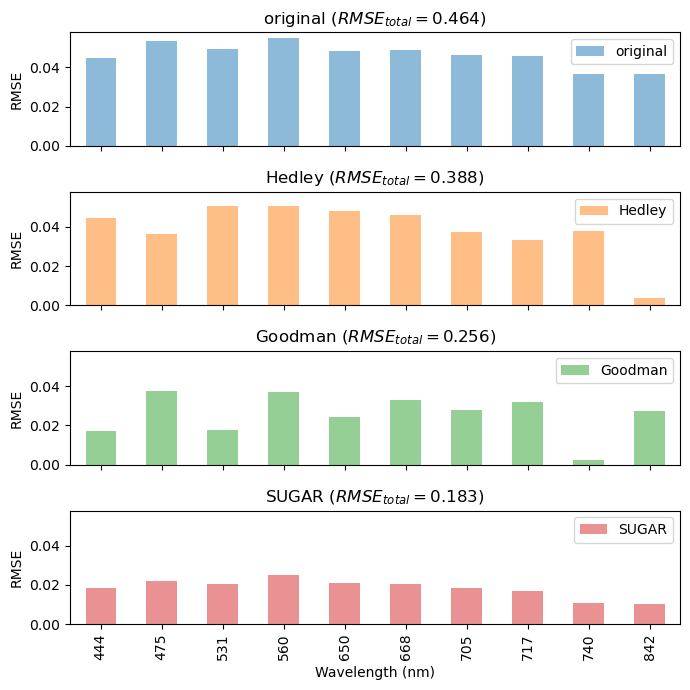

In [65]:
extracted_spectral_dir = r"D:\EPMC_flight\8thSur11Aug\F4\Extracted_Spectral_Information"
extracted_spectral_fp_list = [os.path.join(extracted_spectral_dir,fp) for fp in os.listdir(extracted_spectral_dir)]

VI = ValidateAlgo.ValidateInsitu(extracted_spectral_fp_list,titles,conc_index=2,
                    save_dir=r"D:\EPMC_flight\8thSur11Aug\F4")
VI.plot_conc_spectral()
VI.get_metrics(nrows=5,ncols=2,figsize=(7,15))
VI.compare_rmse(figsize=(7,7))

# Plot spectral and georeference and wql

shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


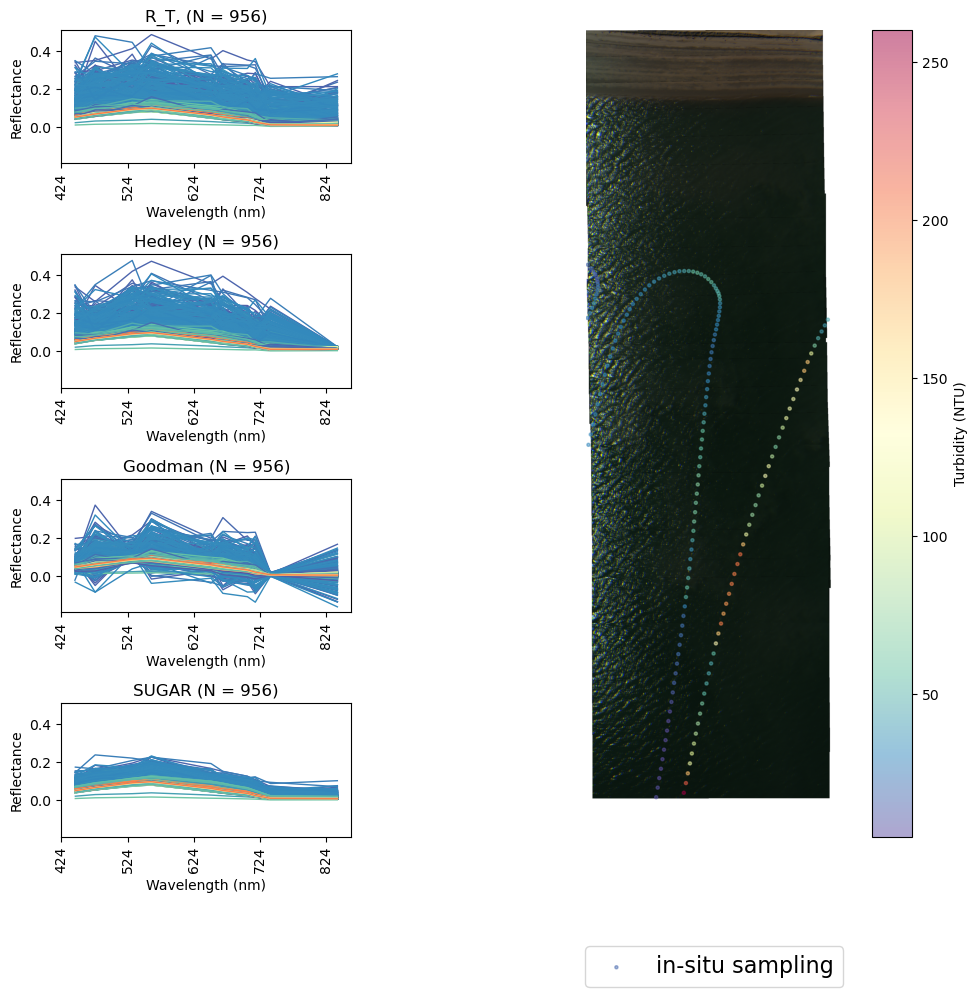

In [66]:
ValidateAlgo.plot_insitu_spectral(PG,VI,s=5,figsize=(10,15))

to-do: normalise image to show plume better